# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Глобальные параметры

In [1]:
SEED = 12345 #random state
NJOBS = -2 #all cpu cores but one
ITERATIONS = 15 #cross val iterations

### Загрузка датафрейма и первичный осмотр

In [2]:
!pip install phik

In [3]:
import pandas as pd
import numpy as np
import phik
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.dummy import DummyRegressor
import time
import warnings

In [4]:
warnings.filterwarnings('ignore')

Загружаем датафрейм с информацией об автомобилях и выведем первые строки:

In [5]:
df = pd.read_csv('./datasets/autos.csv',
                 parse_dates=['LastSeen', 'DateCreated', 'DateCrawled'])

In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

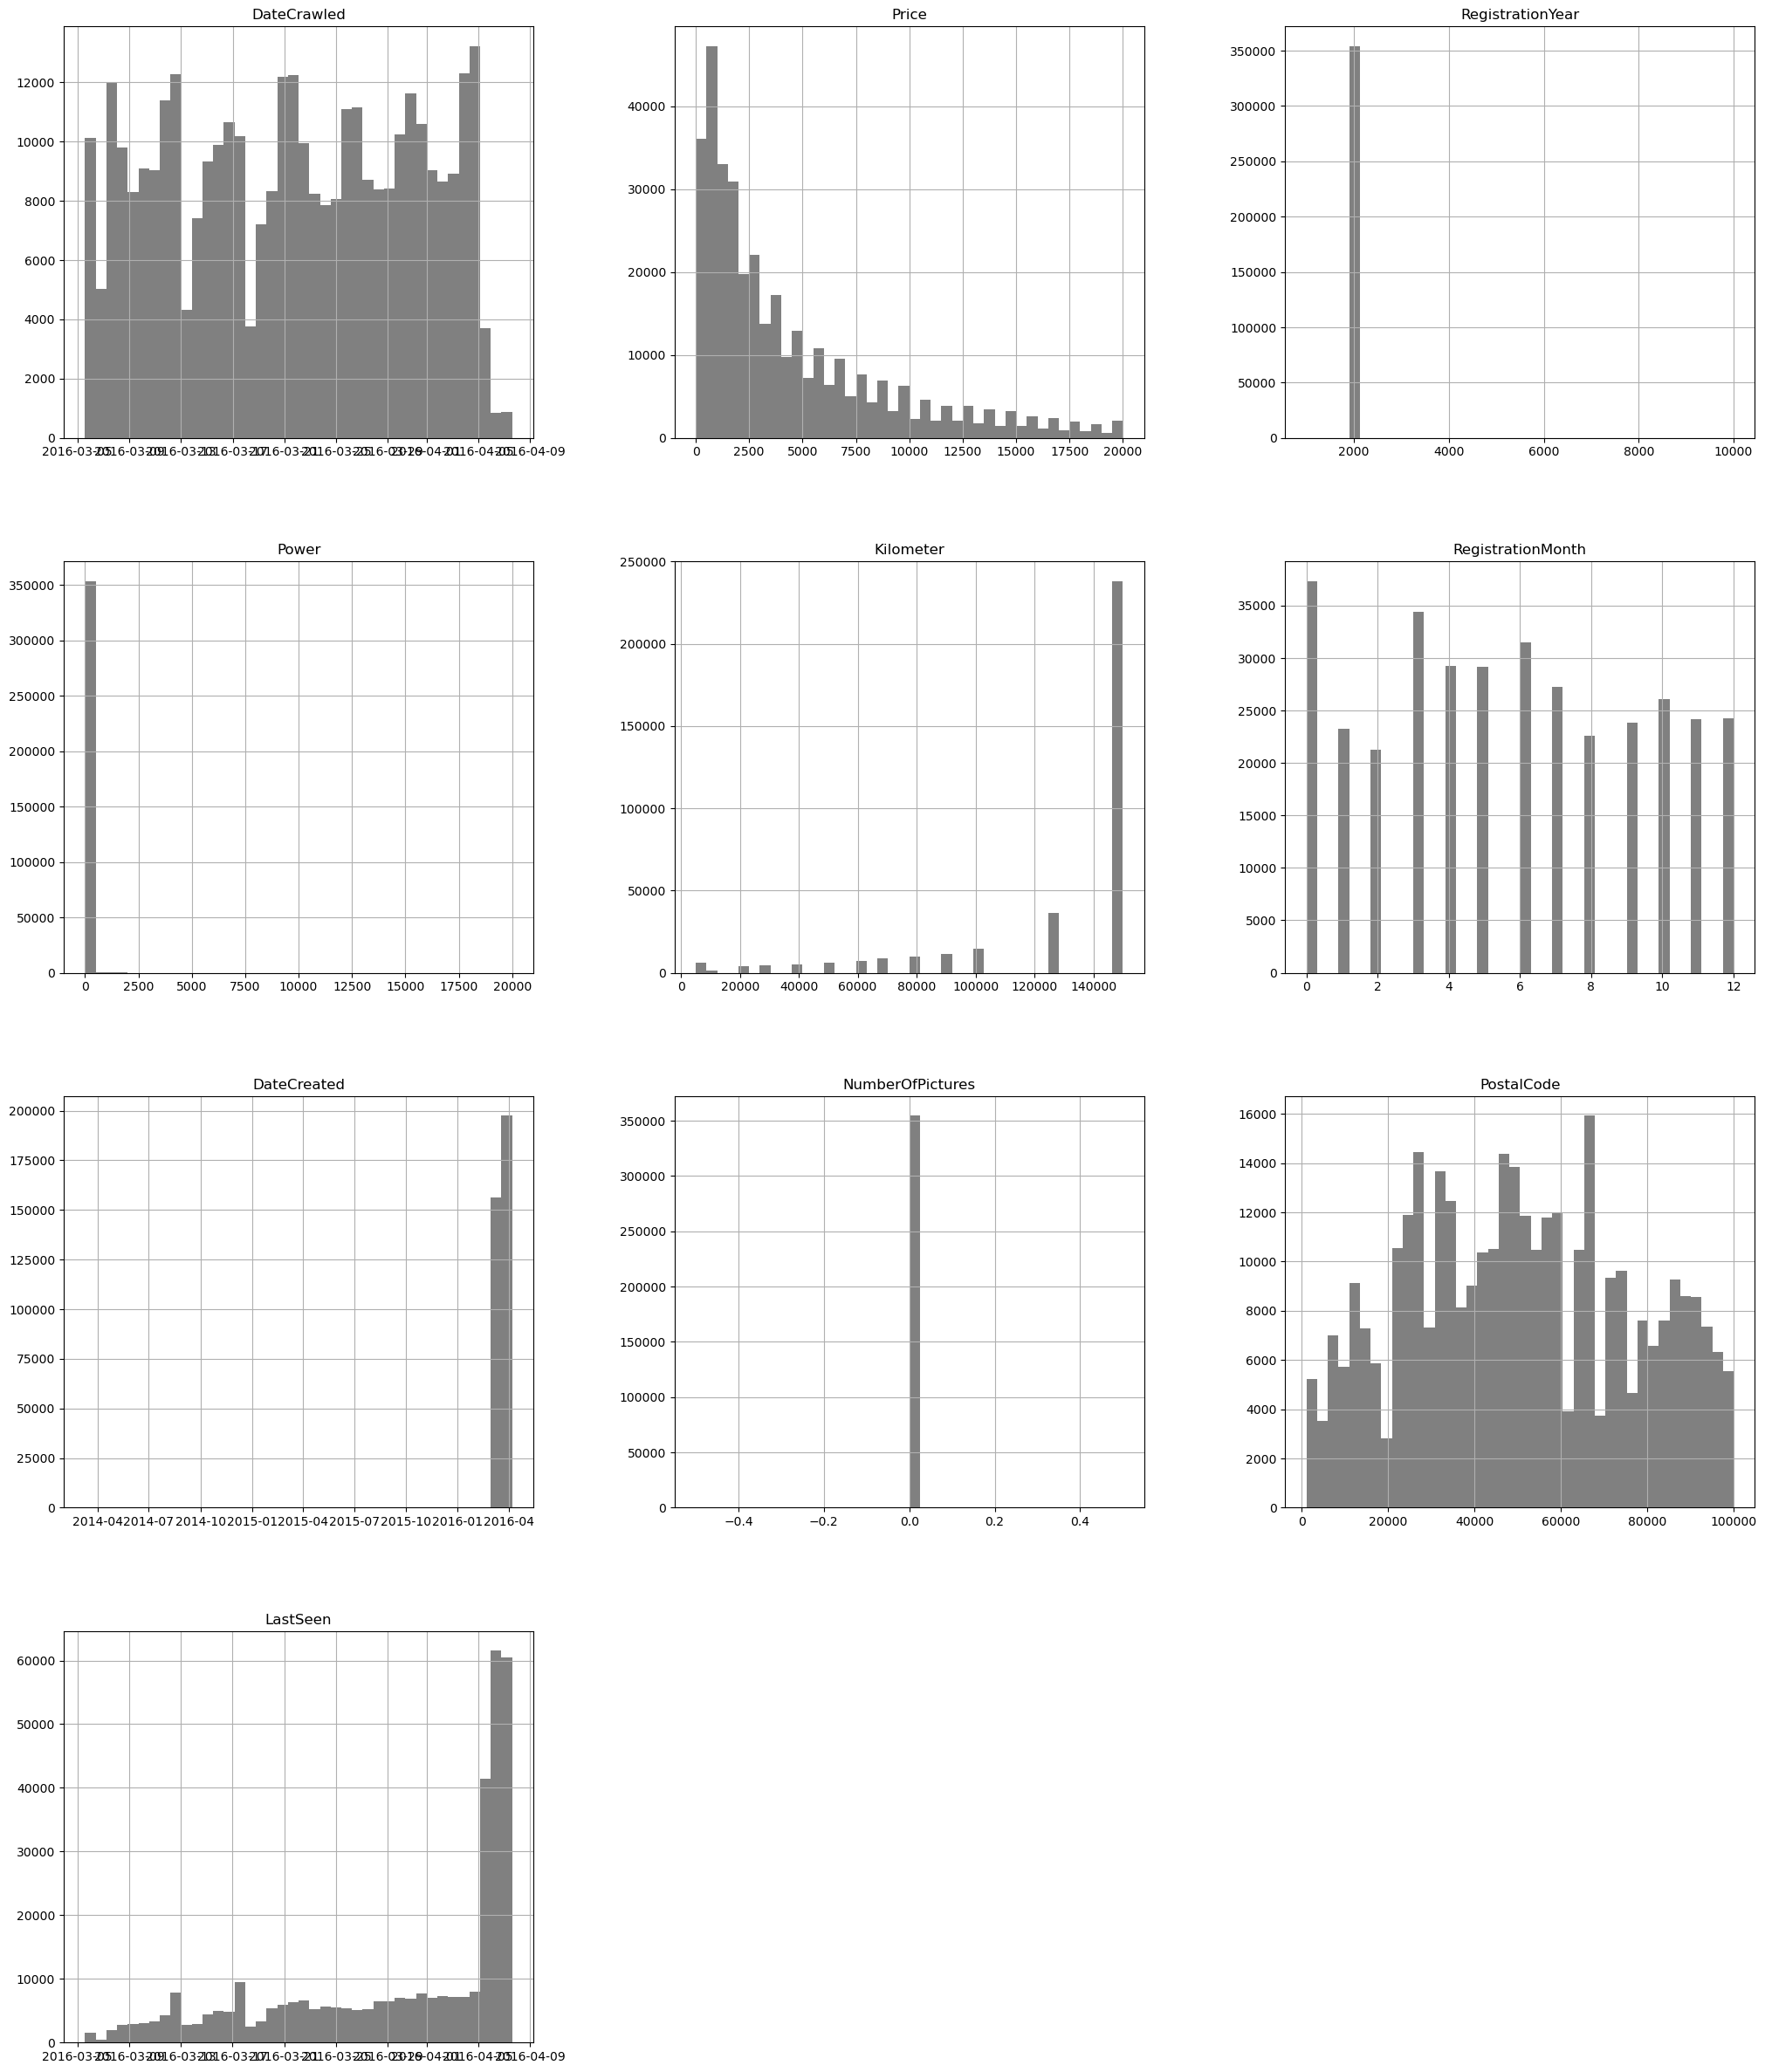

In [8]:
#визуально оценим гистограммы распределения параметров
df.hist(figsize=(25,30),
           color='grey',
           bins=40);

### Стандартизация названий колонок для Python

Приведем названия столбцов к змеиному регистру для удобства:

In [9]:
# находим в названии НЕ первую большую букву и добавляем перед ней подчеркивание
snake_columns = [''.join([col[0].lower()] +
                         ['_'+ch.lower() if ch.isupper() else ch for ch in col[1:]]) for col in df.columns]
df.columns = snake_columns
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Работа с аномалиями и выбросами

Оценим распределение численных параметров:

In [10]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Вывод**

Видим явные выбросы:
- `registration_year` 1000? Интересно конечно. Но вряд ли. 9999? Тоже под вопросом.
- `power` - 20000 л.с. Мощно!
- `number_of_pictures` всегда 0? Под удаление
- `registration_month` - 0? Должно быть от 1 до 12
- `price` - 0

#### `registration_year`

Судя по пост-кодам мы находимся в США. Даже если взять в расчет старые мустанги 50-60х годов, то вряд ли на рынке будет много авто с датой регистрации вне диапазона 1950-2016 (текущий год):

Даты размещения объявлений:

In [11]:
df.date_created.min()

Timestamp('2014-03-10 00:00:00')

In [12]:
df.date_created.max()

Timestamp('2016-04-07 00:00:00')

Слишком старые авто:

In [13]:
df.query('registration_year < 1960').head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:47
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16,0,44628,2016-03-20 16:44:37
1928,2016-03-25 15:58:21,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no,2016-03-25,0,58135,2016-03-25 15:58:21
2273,2016-03-15 21:44:32,1800,convertible,1925,NaN,0,NaN,5000,1,NaN,sonstige_autos,no,2016-03-15,0,79288,2016-04-07 05:15:34
3333,2016-03-15 21:36:20,10500,sedan,1955,manual,30,other,60000,0,petrol,ford,NaN,2016-03-15,0,53498,2016-04-07 08:16:11


Всего у нас почти 350000 объявлений. Смело удаляем эти 422 строки:

In [14]:
df = df[df['registration_year'] > 1960]

Есть и объявления моложе 2016 года:

In [15]:
df.query('registration_year > 2016')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10,0,33397,2016-03-25 10:17:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,NaN,2016-03-11,0,32339,2016-03-12 05:45:02
354140,2016-03-29 16:47:29,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,NaN,2016-03-29,0,38315,2016-04-06 02:44:27
354203,2016-03-17 00:56:26,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17,0,44866,2016-03-29 15:45:04
354253,2016-03-25 09:37:59,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,opel,NaN,2016-03-25,0,45527,2016-04-06 07:46:13


Вряд ли это новые авто, так как пробег весьма высок. И выбрасывать не хочется аж 14530 рядов. Попробуем посчитать средний возраст автомобиля и предположить, что пробег с ним связан:

In [16]:
2016 - df['registration_year'].mean().round()

12.0

Предполагаем, что на возрасте 12 лет достигаем пробега более 150000, на возрасте 0 лет пробег до 5000км:

In [17]:
df.loc[df['registration_year'] > 2016, 'registration_year'] = \
            2016 - round(12/150_000*df['kilometer'])

#### `registration_month`

In [18]:
df.query('registration_month == 0')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11,0,2943,2016-04-07 03:46:09
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,2016-03-17,0,88433,2016-04-04 04:17:32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354305,2016-04-03 13:46:24,3500,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03,0,74579,2016-04-05 12:44:38
354318,2016-03-15 19:57:11,400,wagon,1991,manual,0,legacy,150000,0,petrol,subaru,NaN,2016-03-15,0,24558,2016-03-19 15:49:00
354326,2016-03-31 19:36:18,1300,small,1999,manual,75,2_reihe,125000,0,NaN,peugeot,NaN,2016-03-31,0,35102,2016-04-06 13:44:44
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30,0,25436,2016-04-07 13:50:41


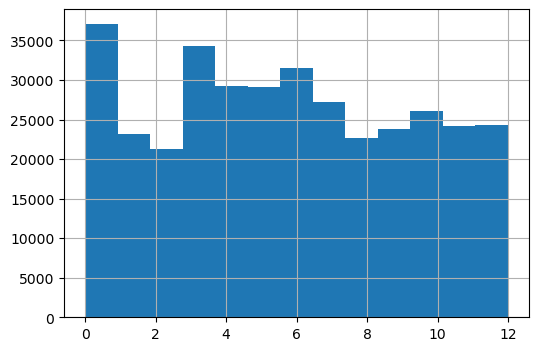

In [19]:
df['registration_month'].hist(bins=13,
                             figsize=(6,4));

В целом, распределение месяца регистрации более-менее равномерное.

Так как значений много, удалять строки не хочется, заполним случайным значением от 1 до 12, пусть будет равномерное распределение:

In [20]:
random_months = df.loc[df['registration_month'] == 0, 'registration_month']
random_months = random_months.apply(lambda x: np.random.randint(1, 12))

In [21]:
df.loc[df['registration_month'] == 0, 'registration_month'] = random_months

#### `power`

Гугл говорит следующее:
- На сегодняшний день самым мощным легковым автомобилем в мире назван Dagger GT компании TranStar Racing LLC. Только представьте: мощность его двигателя превышает 2000 лошадиных сил.

In [22]:
df.query('power > 2000')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,NaN,2016-04-02,0,65830,2016-04-06 11:46:49
11039,2016-03-25 19:55:32,0,sedan,1998,manual,10317,other,150000,8,petrol,fiat,no,2016-03-25,0,57520,2016-04-01 19:16:33
19092,2016-03-20 17:54:04,9750,wagon,2005,auto,2729,5er,150000,7,gasoline,bmw,no,2016-03-20,0,21376,2016-03-23 02:48:53
25232,2016-03-28 19:57:39,10900,bus,2009,manual,10520,caddy,150000,6,gasoline,volkswagen,no,2016-03-28,0,36272,2016-04-07 02:47:02
33952,2016-03-09 11:37:03,3740,small,2006,manual,6920,aygo,90000,10,NaN,toyota,no,2016-03-09,0,94116,2016-03-17 05:16:32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346639,2016-03-25 12:55:36,1300,sedan,2000,manual,12512,carisma,150000,9,petrol,mitsubishi,NaN,2016-03-25,0,42105,2016-04-06 14:44:53
346690,2016-03-24 11:50:41,7498,NaN,2004,auto,2018,5er,150000,9,NaN,bmw,no,2016-03-24,0,59425,2016-03-30 12:46:26
348137,2016-03-16 21:48:39,850,sedan,1993,auto,9012,golf,150000,6,petrol,volkswagen,NaN,2016-03-16,0,14482,2016-04-03 09:17:43
348237,2016-04-04 12:38:11,3000,coupe,2007,manual,2007,corsa,150000,3,gasoline,opel,yes,2016-04-04,0,72218,2016-04-04 12:38:11


Ох какой мощный golf.

Рядов всего 120 - под удаление:

In [23]:
df = df[df['power'] <= 2000]

Также есть очень низкие и нулевые значения:

Опять из гугла:

- Peel P50 Мощность: 4,2 л. с. Максимальная скорость: 61 км/ч. Длина этого мини-автомобиля составляет всего 134,2 сантиметра.

In [24]:
df.query('power <= 5')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,8,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,5,NaN,opel,no,2016-03-17,0,88433,2016-04-04 04:17:32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354346,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07,0,61169,2016-03-08 21:28:38
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02,0,81825,2016-04-06 20:47:12
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27,0,26624,2016-03-29 10:17:23
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49


Значений много, удалять не хочется. Заменим их медианами: 

In [25]:
df.loc[df['power'] <= 5, 'power'] = df['power'].median()

#### `number_of_pictures`

In [26]:
df['number_of_pictures'].eq(0).all()

True

Столбец целиком нулевой, удаляем:

In [27]:
df = df.drop(['number_of_pictures'], axis=1)

#### `price`

Столбец является таргетным. Для избежания каких-либо утечек мы можем себе позволить только удаление строк с выбросами. Допустим, что цена автомобиля не может быть ниже 100 долларов за нечто совсем старое и ненужное:

In [28]:
df[df['price'] < 100]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,105,corsa,150000,1,petrol,opel,NaN,2016-03-26,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28,40589,2016-04-06 12:15:54
111,2016-03-19 18:40:12,0,NaN,2016,manual,105,golf,5000,12,petrol,volkswagen,NaN,2016-03-19,21698,2016-04-01 08:47:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10,22559,2016-03-12 23:46:32
354309,2016-03-09 22:37:41,99,small,1999,manual,60,arosa,150000,1,petrol,seat,yes,2016-03-09,91301,2016-04-06 22:15:32


In [29]:
df = df[df['price'] >= 100]

### Работа с пропусками в данных

In [30]:
pd.DataFrame(round(df.isna().mean()*100,6)).style.background_gradient('coolwarm')

,0
date_crawled,0.000000
price,0.000000
vehicle_type,9.532927
registration_year,0.000000
gearbox,4.742089
power,0.000000
model,4.947361
kilometer,0.000000
registration_month,0.000000
fuel_type,8.276044


Предположим, что в столбце `repaired` отсутствие значения говорит все же о том, что автомобиль не ремонтировался, заменим NaN на no:

In [31]:
df['repaired'] = df['repaired'].fillna('no')

Типом топлива по умолчанию будет бензин:

In [32]:
df['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Стоит отметить, что в Америке бензин чаще называют *gasoline*, а *petrol* - британское название. Избавимся от британцев:

In [33]:
df.loc[df['fuel_type'] == 'petrol', 'fuel_type'] = 'gasoline'

In [34]:
df['fuel_type'] = df['fuel_type'].fillna('gasoline')

Пропуски в `vehicle_type`, `model` заполним новым типом *other*:

In [35]:
df['vehicle_type'] = df['vehicle_type'].fillna('other')
df['model'] = df['model'].fillna('other')

Коробка передач в наше время чаще все же автомат или вариатор:

In [36]:
df['gearbox'] = df['gearbox'].fillna('auto')

In [37]:
pd.DataFrame(round(df.isna().mean()*100,6)).style.background_gradient('coolwarm')

,0
date_crawled,0.000000
price,0.000000
vehicle_type,0.000000
registration_year,0.000000
gearbox,0.000000
power,0.000000
model,0.000000
kilometer,0.000000
registration_month,0.000000
fuel_type,0.000000


### Проверка на дубликаты

In [38]:
df.duplicated().sum()

5

In [39]:
df = df.drop_duplicates()

### Повторный осмотр подготовленного датасета

In [40]:
df.describe()

,price,registration_year,power,kilometer,registration_month,postal_code
count,340520.000000,340520.000000,340520.000000,340520.000000,340520.000000,340520.000000
mean,4586.327502,2002.796925,119.568363,128582.036297,6.357823,50701.000094
std,4512.205522,6.516468,60.144140,37136.720638,3.334534,25730.282095
min,100.000000,1961.000000,6.000000,5000.000000,1.000000,1067.000000
25%,1200.000000,1999.000000,83.000000,125000.000000,3.000000,30455.000000
50%,2900.000000,2003.000000,105.000000,150000.000000,6.000000,49525.000000
75%,6500.000000,2007.000000,143.000000,150000.000000,9.000000,71229.000000
max,20000.000000,2016.000000,2000.000000,150000.000000,12.000000,99998.000000


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340520 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        340520 non-null  datetime64[ns]
 1   price               340520 non-null  int64         
 2   vehicle_type        340520 non-null  object        
 3   registration_year   340520 non-null  int64         
 4   gearbox             340520 non-null  object        
 5   power               340520 non-null  int64         
 6   model               340520 non-null  object        
 7   kilometer           340520 non-null  int64         
 8   registration_month  340520 non-null  int64         
 9   fuel_type           340520 non-null  object        
 10  brand               340520 non-null  object        
 11  repaired            340520 non-null  object        
 12  date_created        340520 non-null  datetime64[ns]
 13  postal_code         340520 no

**Вывод**

- Проведена работа с пропусками и аномалиями
- Выброшены *сильно* аномальные строки и пустые столбцы

## Обучение моделей

### Подготовка выборок

Для начала избавимся от ненужных столбцов `date_crawled`, `date_created`, `last_seen`, `postal_code` - это просто техническая информация c сайта:

In [42]:
df = df.drop(['date_crawled', 'date_created', 'last_seen', 'postal_code'], axis=1)

### Проверка коллинеарности фич и таргета

Рассмотрим хитмап корреляций `phik` (умеет работать с категориальными фичами, определяет линейные и нелинейные связи):

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer', 'registration_month']


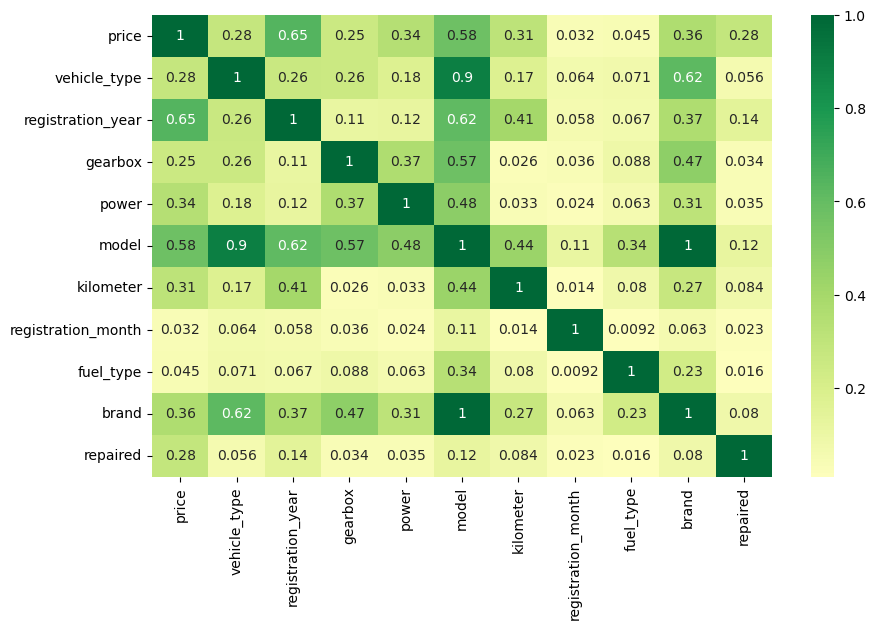

In [43]:
plt.figure(figsize=(10,6))
sns.heatmap(df.phik_matrix(),
            cmap='RdYlGn',
            center=0,
            annot=True);

Сильной корреляцией будем считать R2 > 0.9. Из таблицы следует, что имеется сильная зависимость между `model` и `vehicle_type`

Поскольку мы уже проводили работу со столбцом `vehicle_type` (были пустые значения), а в столбце `model` пропусков изначально не было, то удалим столбец `vehicle_type`, как коллинеарный:

In [44]:
df = df.drop(['vehicle_type'], axis=1)

Таким образом определяем выборки `features` и `target`:

In [45]:
features = df.drop(['price'], axis=1)
target = df['price']
print(features.shape, target.shape)

(340520, 9) (340520,)


Разделяем выборки на train/test:

In [46]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=SEED)
print(features_train.shape, target_train.shape, features_test.shape, target_test.shape)

(272416, 9) (272416,) (68104, 9) (68104,)


### Нормировка признаков

In [47]:
df.columns

Index(['price', 'registration_year', 'gearbox', 'power', 'model', 'kilometer',
       'registration_month', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

Численные и категориальные столбцы:

In [48]:
numeric = ['power', 'kilometer', 'registration_year', 'registration_month']
category = ['gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [49]:
#учим скелер на трейн фичах
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
#применяем ко всем фичам
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Label-кодирование

Для модели решающего дерева необходимо провести Label/OHE кодирование категориальных фич, а бустинговые модели могут работать и с "сырыми" категориальными признаками. У нас довольно большой датасет, так что возьмем Label:

Судя по методу `describe` и гистограммам у большого количества параметров есть выбросы относительно визуально нормального распределения.
Для улучшения нормирования возьмем данные из 99.8% межквантильного интервала.

Подготовим Label-кодировщик из `scikit-learn`:

In [50]:
encoder_label = LabelEncoder()
for column in category:
    encoder_label.fit(features_train[column].astype('str'))
    features_train[column] = encoder_label.transform(features_train[column].astype('str'))
    features_test[column] = encoder_label.transform(features_test[column].astype('str'))

## Анализ моделей

Размеры выборок:

In [51]:
print(features_train.shape, target_train.shape, features_test.shape, target_test.shape)

(272416, 9) (272416,) (68104, 9) (68104,)


По условию задачи нужно обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. И для каждой модели попробовать разные гиперпараметры.

Не бустинговой моделью будет хорошо зарекомендовавший себя `DecisionTreeRegressor`
Также применим `LightGBM` и `CatBoostRegressor`

Требуемая метрика `RMSE` не является стандартной при обучении, нам нужен кастомный скорер:

In [52]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

### DecisionTreeRegressor

Ключевые гиперпараметры случайного леса:
`n_estimator`,`max_depth`,`min_samples_leaf`, `max_leaf_nodes`

In [53]:
dtr = DecisionTreeRegressor(random_state = SEED)

In [54]:
parameters = {'splitter': ['best', 'random'], #default=”best”
              'max_depth': [2*i for i in range(3, 42)], #default=None
              'min_samples_leaf': [i for i in range(1, 31)], #default=1
              'max_leaf_nodes': [None]+[10*i for i in range(1, 31)]} #default=None

In [55]:
dtr_rs = RandomizedSearchCV(estimator=dtr,
                            param_distributions=parameters,
                            scoring=rmse_scorer,
                            n_jobs=NJOBS,
                            cv=5,
                            random_state=SEED,
                            n_iter=ITERATIONS)

In [56]:
%%time
dtr_rs.fit(features_train, target_train)

CPU times: total: 922 ms
Wall time: 5.74 s


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
                   n_iter=15, n_jobs=-2,
                   param_distributions={'max_depth': [6, 8, 10, 12, 14, 16, 18,
                                                      20, 22, 24, 26, 28, 30,
                                                      32, 34, 36, 38, 40, 42,
                                                      44, 46, 48, 50, 52, 54,
                                                      56, 58, 60, 62, 64, ...],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90,
                                                           100, 110, 120, 130,
                                                           140, 150, 160, 170,
                                                           180, 190, 200, 210,
                                                           220, 230, 240, 250,
                                                           260, 270, 280, 290, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30],
                                        'splitter': ['best', 'random']},
                   random_state=12345,
                   scoring=make_scorer(rmse, greater_is_better=False))

In [57]:
#лучшие параметры
dtr_rs.best_params_

{'splitter': 'best',
 'min_samples_leaf': 24,
 'max_leaf_nodes': 280,
 'max_depth': 34}

In [58]:
print(f'crossval RMSE для DecisionTreeRegressor {-dtr_rs.best_score_}')

crossval RMSE для DecisionTreeRegressor 2123.30099165116


### LGBMRegresor

In [59]:
lgbr = LGBMRegressor(random_state=SEED, n_jobs=NJOBS)

In [60]:
parameters = {'num_leaves':[5, 10, 20, 30],
              'min_child_samples': [10, 50, 100, 150],
              'max_depth': [3, 8, 12, 15],
              'learning_rate': [0.01, 0.05, 0.15, 0.3]}

In [61]:
lgbr_rs = RandomizedSearchCV(estimator=lgbr,
                            param_distributions=parameters,
                            scoring=rmse_scorer,
                            n_jobs=NJOBS,
                            cv=5,
                            random_state=SEED,
                            n_iter=ITERATIONS)

In [62]:
%%time
lgbr_rs.fit(features_train, target_train)

CPU times: total: 3.52 s
Wall time: 18.8 s


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(n_jobs=-2, random_state=12345),
                   n_iter=15, n_jobs=-2,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.15,
                                                          0.3],
                                        'max_depth': [3, 8, 12, 15],
                                        'min_child_samples': [10, 50, 100, 150],
                                        'num_leaves': [5, 10, 20, 30]},
                   random_state=12345,
                   scoring=make_scorer(rmse, greater_is_better=False))

In [63]:
lgbr_rs.best_params_

{'num_leaves': 20,
 'min_child_samples': 100,
 'max_depth': 8,
 'learning_rate': 0.3}

In [64]:
print(f'crossval RMSE для LGBMRegressor {-lgbr_rs.best_score_}')

crossval RMSE для LGBMRegressor 1829.557514495403


### CatBoostRegressor

В библиотеке `catboost` есть свой собственный рендом-серч, воспользуемся им

In [65]:
%%time
cbr = CatBoostRegressor(loss_function='RMSE',
                           verbose=False,
                           task_type='CPU',
                           random_state=SEED)

grid = {'iterations': [300, 600],
        'learning_rate': [0.01, 0.03, 0.05],
        'depth': [2, 4, 8],
        'l2_leaf_reg': [1, 5, 10]}

cbr_rs = cbr.randomized_search(grid,
                               X=features_train,
                               y=target_train,
                               plot=True,
                               n_iter=ITERATIONS,
                               partition_random_seed=SEED,
                               verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 2179.219428
bestIteration = 299


bestTest = 2271.015811
bestIteration = 299


bestTest = 2272.926421
bestIteration = 299


bestTest = 2152.171513
bestIteration = 599


bestTest = 2366.748223
bestIteration = 599


bestTest = 2159.542465
bestIteration = 599


bestTest = 1999.665369
bestIteration = 599


bestTest = 2160.756189
bestIteration = 599


bestTest = 1942.282338
bestIteration = 599


bestTest = 2143.339706
bestIteration = 299


bestTest = 1880.479749
bestIteration = 299


bestTest = 1884.049818
bestIteration = 299


bestTest = 2148.586925
bestIteration = 299


bestTest = 1865.969847
bestIteration = 599


bestTest = 1996.23581
bestIteration = 599

Training on fold [0/3]

bestTest = 1874.335156
bestIteration = 599

Training on fold [1/3]

bestTest = 1855.273705
bestIteration = 599

Training on fold [2/3]

bestTest = 1864.121301
bestIteration = 599

CPU times: total: 1min 33s
Wall time: 1min 33s


In [66]:
cbr_rs['params']

{'depth': 8, 'l2_leaf_reg': 5, 'iterations': 600, 'learning_rate': 0.03}

In [67]:
print('crossval RMSE для CatBoostRegressor', min(cbr_rs['cv_results']['test-RMSE-mean']))

crossval RMSE для CatBoostRegressor 1864.5767206359626


Сводная таблица результатов поиска лучших параметров:

In [68]:
results = pd.DataFrame({'RMSE': [-dtr_rs.best_score_, -lgbr_rs.best_score_,
                                min(cbr_rs['cv_results']['test-RMSE-mean'])]},
                      index=['DTR','LGBR', 'CBR'])
                       
results

,RMSE
DTR,2123.300992
LGBR,1829.557514
CBR,1864.576721


Лучшей моделью показал себя `CatBoostRegressor`. Позже проверим его на тестовой выборке.

### Оценка времени обучения и предсказания моделей

#### DecisionTreeRegressor

In [69]:
dtr_rs.best_params_

{'splitter': 'best',
 'min_samples_leaf': 24,
 'max_leaf_nodes': 280,
 'max_depth': 34}

In [70]:
dtr = DecisionTreeRegressor(random_state=SEED,
                           splitter=dtr_rs.best_params_['splitter'],
                           min_samples_leaf=dtr_rs.best_params_['min_samples_leaf'],
                           max_leaf_nodes=dtr_rs.best_params_['max_leaf_nodes'],
                           max_depth=dtr_rs.best_params_['max_depth'])

In [71]:
%%time
start = time.time()
dtr.fit(features_train, target_train);
end = time.time()
dtr_time_learn = end - start

CPU times: total: 203 ms
Wall time: 408 ms


In [72]:
%%time
start = time.time()
predictions = dtr.predict(features_test);
end = time.time()
dtr_time_pred = end - start

CPU times: total: 0 ns
Wall time: 9.52 ms


#### LGBMRegresor

In [73]:
lgbr_rs.best_params_

{'num_leaves': 20,
 'min_child_samples': 100,
 'max_depth': 8,
 'learning_rate': 0.3}

In [74]:
lgbr = LGBMRegressor(random_state=SEED,
                    n_jobs=NJOBS,
                    num_leaves=lgbr_rs.best_params_['num_leaves'],
                    min_child_samples=lgbr_rs.best_params_['min_child_samples'],
                    max_depth=lgbr_rs.best_params_['max_depth'],
                    learning_rate=lgbr_rs.best_params_['learning_rate'])

In [75]:
%%time
start = time.time()
lgbr.fit(features_train, target_train, eval_set=(features_test, target_test), verbose=20);
end = time.time()
lgbr_time_learn = end - start

[20]	valid_0's l2: 3.9075e+06
[40]	valid_0's l2: 3.65765e+06
[60]	valid_0's l2: 3.47535e+06
[80]	valid_0's l2: 3.39273e+06
[100]	valid_0's l2: 3.32985e+06
CPU times: total: 3.72 s
Wall time: 354 ms


In [76]:
%%time
start = time.time()
predictions = lgbr.predict(features_test);
end = time.time()
lgbr_time_pred = end - start

CPU times: total: 391 ms
Wall time: 33.6 ms


#### CatBoostRegressor

In [77]:
cbr_rs['params']

{'depth': 8, 'l2_leaf_reg': 5, 'iterations': 600, 'learning_rate': 0.03}

In [78]:
cbr = CatBoostRegressor(loss_function='RMSE',
                        random_state=SEED,
                        thread_count=-1,
                        depth=cbr_rs['params']['depth'],
                        l2_leaf_reg=cbr_rs['params']['l2_leaf_reg'],
                        iterations=cbr_rs['params']['iterations'],
                        learning_rate=cbr_rs['params']['learning_rate'])

In [79]:
%%time
start = time.time()
cbr.fit(features_train, target_train, eval_set=(features_test, target_test), verbose=50);
end = time.time()
cbr_time_learn = end - start

0:	learn: 4423.3737458	test: 4409.1140157	best: 4409.1140157 (0)	total: 14.1ms	remaining: 8.43s
50:	learn: 2441.2213944	test: 2435.3272965	best: 2435.3272965 (50)	total: 643ms	remaining: 6.92s
100:	learn: 2121.8361726	test: 2122.7031500	best: 2122.7031500 (100)	total: 1.27s	remaining: 6.27s
150:	learn: 2025.7786070	test: 2030.3556476	best: 2030.3556476 (150)	total: 1.86s	remaining: 5.54s
200:	learn: 1981.4560656	test: 1987.7638615	best: 1987.7638615 (200)	total: 2.45s	remaining: 4.87s
250:	learn: 1950.7881929	test: 1959.1912710	best: 1959.1912710 (250)	total: 3.04s	remaining: 4.23s
300:	learn: 1926.9672716	test: 1936.5507573	best: 1936.5507573 (300)	total: 3.64s	remaining: 3.61s
350:	learn: 1905.6910162	test: 1916.6341870	best: 1916.6341870 (350)	total: 4.23s	remaining: 3s
400:	learn: 1889.4038443	test: 1901.6806020	best: 1901.6806020 (400)	total: 4.83s	remaining: 2.4s
450:	learn: 1874.0115864	test: 1887.8968450	best: 1887.8968450 (450)	total: 5.42s	remaining: 1.79s
500:	learn: 1861.54

In [80]:
%%time
start = time.time()
predictions = cbr.predict(features_test);
end = time.time()
cbr_time_pred = end - start

CPU times: total: 0 ns
Wall time: 10.5 ms


In [81]:
pd.DataFrame({'fit time (ms)' : [dtr_time_learn, lgbr_time_learn, cbr_time_learn],
             'predict time (ms)' : [dtr_time_pred, lgbr_time_pred, cbr_time_pred]},
             index=['DTR', 'LGBR', 'CBR'])

,fit time (ms),predict time (ms)
DTR,0.407871,0.009523
LGBR,0.354211,0.033646
CBR,7.351294,0.010483


**Вывод**
- Время обучения модели решаюшего древа ниже, чем у бустинговых, но и точность ниже

## Проверка лучшей модели на тестовой выборке

Лучшей моделью выбран `CatBoostregressor`:

In [82]:
cbr = CatBoostRegressor(loss_function='RMSE',
                        depth=cbr_rs['params']['depth'],
                        iterations=cbr_rs['params']['iterations'],
                        learning_rate=cbr_rs['params']['learning_rate'],
                        l2_leaf_reg=cbr_rs['params']['l2_leaf_reg'],
                        thread_count=-1,
                        random_state=SEED)

cbr.fit(features_train, target_train, 
        eval_set=(features_test, target_test),
        verbose=False, plot=True)


print(cbr.get_best_score())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'RMSE': 1838.7578592404145}, 'validation': {'RMSE': 1857.8893098689846}}


## Проверка адекватности модели

Для проверки адекватности модели воспользуемся DummyRegressor:

In [83]:
dr = DummyRegressor(strategy='median')
dr.fit(features_train, target_train)
predictions_dummy = dr.predict(features_test)
dr_score = rmse(predictions_dummy, target_test)

In [84]:
pd.DataFrame({'RMSE' : [cbr.get_best_score()['validation']['RMSE'], dr_score]},
             index = ['CBR', 'DR'])

,RMSE
CBR,1857.889310
DR,4798.804381


**Вывод**
- Модель прошла проверку на адекватность

## Общий вывод

- Проведен анализ данных, выполнена работа с аномалиями, дубликатами и пропусками
- Подготовлены фичи и таргет, выполена проверка на коллинеарность
- Выполнены label преобразования категориальных столбцов и нормирование численных
- Протестированы модели DecisionTreeRegressor, LGBMRegressor, CatBoostRegressor
- Найдены лучшие параметры с применением Randomized Search
- Оценено быстродействие всех моделей
- Выбрана лучшая модели и проверена на адекватность